In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/mnist_train_unzipped/mnist_train.csv")

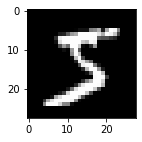

Lable: 5


In [28]:
# Display or plot an image
def display_image(idx):
  plt.figure(figsize=(2,2))
  labels = data["label"]
  data_drop_label = data.drop(["label"], axis=1)
  grid_data = data_drop_label.iloc[idx].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
  plt.imshow(grid_data, interpolation = "none", cmap = "gray")
  plt.show()

  print("Lable:", labels[idx])

display_image(0)

In [4]:
train_df, test_df = train_test_split(data, test_size=0.2)  #Split data into train and test.
train_labels = train_df["label"]
test_labels =test_df["label"]
train_data = train_df.drop("label",axis=1)
test_data = test_df.drop("label", axis=1)
train_data = np.array(train_data.T)/255.
test_data = np.array(test_data.T)/255.      #Normalize the data.
n, m = train_data.shape

In [5]:
def init_params(): #Initialize Parameters.
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5 
    b2 = np.random.rand(10, 1) - 0.5
    W3 = np.random.rand(10, 10) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    k0 = np.random.rand(1)
    k1 = np.random.rand(1)
    return W1, b1, W2, b2, W3, b3, k0, k1 

def activaton(Z, k0, k1):  #Define activation function.
    return k0 +(k1*Z)

def softmax(Z):            #Define softmax function
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X):   #Define forward propagation.
    Z1 = W1.dot(X) + b1
    A1 = activaton(Z1, k0, k1)
    Z2 = W2.dot(A1) + b2
    A2 = activaton(Z2, k0, k1)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def actva_deri(Z, k0, k1):     #Derivative of activation function.
    return k1

def one_hot(Y):                #One hot encoding for labels.
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, k0, k1, X, Y):    #define backward propagation.
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    dA2 = W3.T.dot(dZ3)
    dZ2 = W3.T.dot(dZ3) * actva_deri(Z2, k0, k1)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dA1 = W2.T.dot(dZ2)
    dZ1 = W2.T.dot(dZ2) * actva_deri(Z1, k0, k1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    dk0 = np.average(dA1)
    dk1 = np.average(dA1*Z1)
    return dW1, db1, dW2, db2, dW3, db3, dk0, dk1

def update_params(W1, b1, W2, b2, W3, b3, k0, k1, dW1, db1, dW2, db2, dW3, db3, dk0, dk1, alpha):    #Update parameters.
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3  
    b3 = b3 - alpha * db3
    k0 = k0 - alpha * dk0
    k1 = k1 - alpha * dk1    
    return W1, b1, W2, b2, W3, b3, k0, k1

In [6]:
def loss_crossentropy(probas, y):          #Categorical cross entopy loss function.
  tanspose_probas = probas.T
  transpose_y = y.T
  training_point_loss = []
  for list_1, list_2 in zip(tanspose_probas, transpose_y):
    for i, j in zip(list_1, list_2):
      training_point_loss.append(np.sum(np.log(i)*(-j)))
  total_loss = np.mean(training_point_loss)
  return total_loss

def get_predictions(A3):                   #make Predictions
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):          #Define accuracy
    return np.sum(predictions == Y) / Y.size

def Test_loss_accuracy(X, W1, b1, W2, b2, W3, b3, k0, k1):     #loss-accuracy calculation for test data.
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
    Test_loss = loss_crossentropy(A3, one_hot(test_labels))
    Test_accuracy = get_accuracy(get_predictions(A3), test_labels)
    return Test_loss, Test_accuracy    

In [9]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3, k0, k1 = init_params()
    print("Initial k0:", k0)
    print("Initial k1:", k1)
    Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst = [], [], [], [], [], []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
        dW1, db1, dW2, db2, dW3, db3, dk0, dk1 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, k0, k1, X, Y)
        W1, b1, W2, b2, W3, b3, k0, k1 = update_params(W1, b1, W2, b2, W3, b3, k0, k1, dW1, db1, dW2, db2, dW3, db3, dk0, dk1,alpha)
        if i % 10 == 0:
          print("\033[1m" + "Iteration" + "\033[0m", i)
          total_loss = loss_crossentropy(A3, one_hot(Y))
          Train_accuracy = get_accuracy(get_predictions(A3), Y)
          Test_loss, Test_accuracy = Test_loss_accuracy(test_data, W1, b1, W2, b2, W3, b3, k0, k1)
          Train_loss_lst.append(total_loss), Train_accuracy_lst.append(Train_accuracy), Test_loss_lst.append(Test_loss), Test_accuracy_lst.append(Test_accuracy)
          k0_lst.append(k0)
          k1_lst.append(k1)
          print("k0 and k1:", k0, k1)
    return W1, b1, W2, b2, W3, b3, k0, k1, Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst 

#### **Model training.**

In [29]:
W1, b1, W2, b2, W3, b3, k0, k1, Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst = gradient_descent(train_data, train_labels, 0.10, 500)

Initial k0: [0.60127614]
Initial k1: [0.42923105]
Iteration 0
k0 and k1: [0.59968832] [0.42470673]
Iteration 10
k0 and k1: [0.59685523] [0.40962832]
Iteration 20
k0 and k1: [0.59680286] [0.41193934]
Iteration 30
k0 and k1: [0.59652712] [0.42406001]
Iteration 40
k0 and k1: [0.59587556] [0.44519756]
Iteration 50
k0 and k1: [0.59497202] [0.47558141]
Iteration 60
k0 and k1: [0.59397535] [0.51424065]
Iteration 70
k0 and k1: [0.59298918] [0.55713446]
Iteration 80
k0 and k1: [0.59196938] [0.59852342]
Iteration 90
k0 and k1: [0.59076568] [0.63536302]
Iteration 100
k0 and k1: [0.58931194] [0.66769032]
Iteration 110
k0 and k1: [0.58764096] [0.69605339]
Iteration 120
k0 and k1: [0.58581511] [0.72069936]
Iteration 130
k0 and k1: [0.58389858] [0.74200866]
Iteration 140
k0 and k1: [0.58195192] [0.76043242]
Iteration 150
k0 and k1: [0.58002707] [0.77634257]
Iteration 160
k0 and k1: [0.57815746] [0.79002725]
Iteration 170
k0 and k1: [0.57635891] [0.80173189]
Iteration 180
k0 and k1: [0.57463633] [0.81

#### **Train_vs_Test Loss and Train_vs_Test Accuracy.**

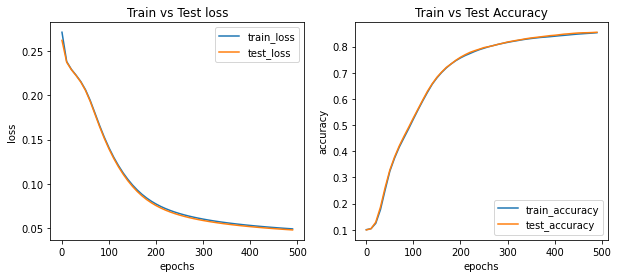

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
epochs = list(range(0,500, 10))
sns.lineplot(epochs,Train_loss_lst,label='train_loss', ax=ax1)
sns.lineplot(epochs,Test_loss_lst,label='test_loss', ax=ax1)
sns.lineplot(epochs,Train_accuracy_lst,label='train_accuracy', ax=ax2)
sns.lineplot(epochs,Test_accuracy_lst,label='test_accuracy', ax=ax2)
ax1.set(xlabel="epochs", ylabel="loss")
ax2.set(xlabel="epochs", ylabel="accuracy")
ax1.title.set_text("Train vs Test loss")
ax2.title.set_text("Train vs Test Accuracy")
plt.show()

In [31]:
print(k0_lst)

[array([0.59968832]), array([0.59685523]), array([0.59680286]), array([0.59652712]), array([0.59587556]), array([0.59497202]), array([0.59397535]), array([0.59298918]), array([0.59196938]), array([0.59076568]), array([0.58931194]), array([0.58764096]), array([0.58581511]), array([0.58389858]), array([0.58195192]), array([0.58002707]), array([0.57815746]), array([0.57635891]), array([0.57463633]), array([0.57298981]), array([0.57141808]), array([0.56991966]), array([0.56849309]), array([0.56713665]), array([0.56584825]), array([0.56462537]), array([0.56346515]), array([0.56236452]), array([0.56132028]), array([0.56032923]), array([0.55938821]), array([0.55849416]), array([0.55764416]), array([0.55683543]), array([0.55606537]), array([0.55533153]), array([0.55463161]), array([0.55396347]), array([0.55332514]), array([0.55271475]), array([0.5521306]), array([0.55157108]), array([0.55103471]), array([0.55052012]), array([0.55002601]), array([0.54955119]), array([0.54909456]), array([0.5486

In [32]:
print(k1_lst)

[array([0.42470673]), array([0.40962832]), array([0.41193934]), array([0.42406001]), array([0.44519756]), array([0.47558141]), array([0.51424065]), array([0.55713446]), array([0.59852342]), array([0.63536302]), array([0.66769032]), array([0.69605339]), array([0.72069936]), array([0.74200866]), array([0.76043242]), array([0.77634257]), array([0.79002725]), array([0.80173189]), array([0.81169474]), array([0.82015471]), array([0.82733921]), array([0.83345089]), array([0.83866245]), array([0.84311794]), array([0.84693695]), array([0.85021918]), array([0.85304817]), array([0.85549426]), array([0.85761682]), array([0.859466]), array([0.86108411]), array([0.86250683]), array([0.86376422]), array([0.86488156]), array([0.86588011]), array([0.86677773]), array([0.8675894]), array([0.86832772]), array([0.86900324]), array([0.86962484]), array([0.87019998]), array([0.87073491]), array([0.87123492]), array([0.87170442]), array([0.87214717]), array([0.87256631]), array([0.87296451]), array([0.873344

In [35]:
print(Train_loss_lst)

[0.27119477222884175, 0.2381484405911428, 0.2293215254233494, 0.22271868277448176, 0.21554016176968324, 0.2063053285374926, 0.1942517157688837, 0.18012560403061362, 0.16587255340159784, 0.15266404110495574, 0.14073489056600422, 0.1301274938645971, 0.12075571488714085, 0.11247838597372212, 0.10517967142420095, 0.09876731247239368, 0.0931654246102574, 0.08830118923596394, 0.08409437242043576, 0.08045871035032799, 0.07730966972675879, 0.07457059611230235, 0.07217514105776492, 0.07006728935394703, 0.06820038740971585, 0.06653588406463286, 0.06504206856028485, 0.06369291250045611, 0.06246705422844829, 0.06134693462448719, 0.06031807793197203, 0.05936850285622869, 0.058488245626097425, 0.05766897639866096, 0.056903691914668056, 0.05618646962861398, 0.055512271000022914, 0.05487678391348376, 0.05427629616543167, 0.05370759359334891, 0.05316787775433339, 0.052654699128092064, 0.052165902669502294, 0.051699583208922754, 0.05125404872935466, 0.05082778996723585, 0.05041945511156449, 0.0500278286

In [36]:
print(Test_loss_lst)

[0.2620192568924626, 0.23737676954524944, 0.22894206886747082, 0.2223366186214894, 0.21499969688387713, 0.20550046538063, 0.1931655334641082, 0.17888571906055242, 0.1645974796156296, 0.15137111634843903, 0.13941913968352312, 0.12877421453977417, 0.11933952180236812, 0.11098181113903002, 0.10359827009498378, 0.09710979645652168, 0.09144975827534689, 0.08654844722148018, 0.0823237164066027, 0.07868481018835843, 0.07554225965861362, 0.07281540497387178, 0.07043532831080909, 0.06834468867056401, 0.06649628555547064, 0.06485138819355526, 0.06337821799334831, 0.06205066991370042, 0.06084725999498968, 0.05975026540856414, 0.058745024051756564, 0.057819365338681296, 0.05696314839123957, 0.05616788780738225, 0.055426450626355754, 0.054732811058963216, 0.05408185201938999, 0.05346920452376827, 0.05289111767579437, 0.052344353313024186, 0.0518261004997713, 0.05133390596956072, 0.0508656173754089, 0.05041933682553803, 0.049993382686661154, 0.04958625804501373, 0.049196624543036076, 0.0488232805712

In [37]:
print(Train_accuracy_lst)

[0.10039583333333334, 0.1041875, 0.12458333333333334, 0.17679166666666668, 0.25245833333333334, 0.32408333333333333, 0.3738958333333333, 0.41602083333333334, 0.4515, 0.4863125, 0.5230208333333334, 0.5587708333333333, 0.5930208333333333, 0.6255833333333334, 0.6561875, 0.6804375, 0.7010833333333333, 0.7187083333333333, 0.7335208333333333, 0.7461041666666667, 0.7566458333333334, 0.7658125, 0.7734583333333334, 0.7812916666666667, 0.7881666666666667, 0.7938541666666666, 0.7995208333333333, 0.804125, 0.8084791666666666, 0.8125625, 0.816125, 0.8195, 0.8225833333333333, 0.82575, 0.8285208333333334, 0.8308541666666667, 0.8329791666666667, 0.835, 0.8363125, 0.8378958333333333, 0.839625, 0.8414166666666667, 0.8429791666666666, 0.844625, 0.846375, 0.8478958333333333, 0.8491875, 0.8504375, 0.8516041666666667, 0.8530625]


In [38]:
print(Test_accuracy_lst)

[0.09941666666666667, 0.10408333333333333, 0.12891666666666668, 0.18658333333333332, 0.2619166666666667, 0.3285, 0.37825, 0.4205833333333333, 0.4573333333333333, 0.49191666666666667, 0.52775, 0.5620833333333334, 0.5964166666666667, 0.6296666666666667, 0.658, 0.68275, 0.7026666666666667, 0.7204166666666667, 0.7336666666666667, 0.7474166666666666, 0.75925, 0.7690833333333333, 0.77775, 0.78425, 0.7900833333333334, 0.79625, 0.79975, 0.8039166666666666, 0.8088333333333333, 0.81275, 0.8175, 0.8206666666666667, 0.824, 0.8269166666666666, 0.83025, 0.833, 0.8350833333333333, 0.83725, 0.8395, 0.84175, 0.84325, 0.8453333333333334, 0.8475833333333334, 0.8489166666666667, 0.8505833333333334, 0.852, 0.85275, 0.8530833333333333, 0.85375, 0.8548333333333333]


**Learnable parameters k0 and k1 vs epochs.**

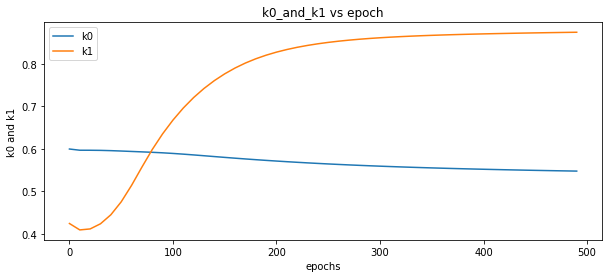

In [44]:
fig = plt.figure(figsize=(10,4))
epochs = list(range(0,500, 10))
plt.plot(epochs,k0_lst,label='k0')
plt.plot(epochs,k1_lst,label='k1')
plt.xlabel('epochs')
plt.ylabel('k0 and k1')
plt.title("k0_and_k1 vs epoch")
plt.legend()

#### **Final values for parameters k0 and k1.**

In [40]:
print("k0:", k0)
print("k1:", k1)

k0: [0.54746898]
k1: [0.87435517]


In [42]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, k0, k1):
  Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
  predict_labels = get_predictions(A3)
  return predict_labels

**F1-Score.**

In [43]:
prdicted_labels = make_predictions(test_data, W1, b1, W2, b2, W3, b3, k0, k1)
ture_labels = test_labels
print(f1_score(ture_labels, prdicted_labels, average='weighted'))

0.8549642703576936
